## Final Project Submission

Please fill out:

- Student name: Billy Mwangi
- Student pace: full time
- Scheduled project review date/time:
- Instructor name: William 
- Blog post URL:


## Importing necessary packages & connecting to database

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3


In [2]:
conn = sqlite3.connect('/home/pk/Desktop/mds/data1/im.db')

## Checking out the data 

In [3]:
movie_gross = pd.read_csv('data/bom.movie_gross.csv')
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


Checking what is contained in im.db database, the two tables movie_basics and movie_ratings

In [4]:
movie_basics = pd.read_sql("""SELECT * FROM movie_basics;""", conn)
movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [5]:
movie_ratings = pd.read_sql("""SELECT * FROM movie_ratings;""", conn)
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


Checking the shape of the data in the movie_basics and movie_ratings tables

In [6]:
movie_basics.shape

(146144, 6)

In [7]:
movie_ratings.shape

(73856, 3)

## Solving the case of missing values in the movie_basics and movie_ratings tables

Checking the number of missing values in the movie_basics and movie_ratings tables

In [8]:
movie_basics.isna().sum()

movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

In [9]:
movie_ratings.isna().sum()

movie_id         0
averagerating    0
numvotes         0
dtype: int64

Figuring out the percentage of missing data in the runtime_minutes in the movie_basics table

Figuring out the percentage of missing data in the genres in the movie_basics table

In [10]:
movie_basics['genres'].isna().sum()/len(movie_basics['genres'])

0.037004598204510616

Since the amount of missing values is little (3.7%), then we can drop the rows with missing values.

In [11]:
movie_basics = movie_basics.dropna(subset=['genres'])
movie_basics.isna().sum()

movie_id               0
primary_title          0
original_title         2
start_year             0
runtime_minutes    28503
genres                 0
dtype: int64

Since there are only two missing values in the original title column in the movie_basics table we can also drop them

In [12]:
movie_basics = movie_basics.dropna(subset=['original_title'])
movie_basics.isna().sum()

movie_id               0
primary_title          0
original_title         0
start_year             0
runtime_minutes    28502
genres                 0
dtype: int64

Figuring out the percentage of missing values in the runtime_minutes column in the movie_basics table

In [13]:
movie_basics['runtime_minutes'].isna().sum()/len(movie_basics['runtime_minutes'])

0.20252391035570652

The percentage of missing values in the runtime_minutes column in the movie_basics table is 20.25%.
We can deal with these missing values by:
1. Ignoring the missing values by dropping the rows, however this might lead to losing some valuable
data.
2. Replacing the missing values by using a measure of central tendency either mean or median. Since this numerical data and not categorical data there is no need of using mode

Let`s check what the effect would be of dropping the rows with missing values by looking at the measures of central tendency and standard deviation before and after dropping the missing values

In [14]:
print(movie_basics['runtime_minutes'].apply(['mean', 'median', 'std']))
movie_basics['runtime_minutes'].isna().sum()

mean       86.261556
median     87.000000
std       167.896646
Name: runtime_minutes, dtype: float64


28502

In [15]:
movie_basics_na_dropped = movie_basics.dropna(subset=['runtime_minutes'])
print(movie_basics_na_dropped['runtime_minutes'].apply(['mean', 'median', 'std']))
movie_basics_na_dropped['runtime_minutes'].isna().sum()

mean       86.261556
median     87.000000
std       167.896646
Name: runtime_minutes, dtype: float64


0

There is no change therefore it\`s best to replace the missing values with mean. Since both mean and median are almost the same we can use mean since it\`s a better measure of central tendecy

In [16]:
mean_runtime = movie_basics['runtime_minutes'].mean()

# replace missing values with the mean value
movie_basics['runtime_minutes'].fillna(mean_runtime, inplace=True)

In [17]:
movie_basics.isna().sum()

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
dtype: int64

We have now solved the case of missing values in the movie_basics table

## Solving the case of duplicates in movie_basics table

In [18]:
movie_basics.duplicated(subset=['original_title']).sum()


7712

There are 7712 duplicate names of movies, so we have to drop the duplicates and keep one.

In [19]:
movie_basics = movie_basics.drop_duplicates(subset=['original_title'])
movie_basics.duplicated(subset=['original_title']).sum()

0

## Overall statistics of the start_year and runtime_minutes in the movie_basics table

Now that we have dropped and replaced the missing values and dropped the duplicated values we can look overall statistics of the start_year and runtime_minutes in the movie_basics table 

In [20]:
movie_basics.describe()

,start_year,runtime_minutes
count,133022.000000,133022.000000
mean,2014.559569,86.338496
std,2.730500,154.048305
min,2010.000000,1.000000
25%,2012.000000,75.000000
50%,2015.000000,86.261556
75%,2017.000000,95.000000
max,2027.000000,51420.000000


### Let`s look at the relationship between the start_year and the average movie run_time

In [21]:
grouped_movie_runtime = movie_basics.groupby(['start_year'])['runtime_minutes'].mean()
grouped_movie_runtime = pd.DataFrame(grouped_movie_runtime)
grouped_movie_runtime

,runtime_minutes
start_year,
2010,85.839298
2011,86.538555
2012,89.079883
2013,85.369896
2014,84.842682
2015,85.803347
2016,85.217588
2017,85.915467
2018,87.348762


In [22]:
grouped_movie_runtime.reset_index()
grouped_movie_runtime

,runtime_minutes
start_year,
2010,85.839298
2011,86.538555
2012,89.079883
2013,85.369896
2014,84.842682
2015,85.803347
2016,85.217588
2017,85.915467
2018,87.348762


## Merging the movie_basics and movie_ratings

The movie_basics and movie_ratings tables have the same column movie_id showing that they are related tables we can merge them together so as to conduct some analysis

In [23]:
movie_ratings_basics = pd.merge(movie_basics, movie_ratings, on='movie_id', how='inner')
movie_ratings_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.000000,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.000000,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.000000,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,86.261556,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.000000,"Comedy,Drama,Fantasy",6.5,119


In [24]:
movie_ratings_basics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69368 entries, 0 to 69367
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         69368 non-null  object 
 1   primary_title    69368 non-null  object 
 2   original_title   69368 non-null  object 
 3   start_year       69368 non-null  int64  
 4   runtime_minutes  69368 non-null  float64
 5   genres           69368 non-null  object 
 6   averagerating    69368 non-null  float64
 7   numvotes         69368 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.8+ MB


## Number of Votes by Year

In [25]:
votes_grouped = movie_ratings_basics.groupby('start_year')['numvotes'].mean().sort_values(ascending= False)
votes_grouped

start_year
2010    4605.929609
2013    4530.501118
2011    4514.282520
2012    4361.501901
2014    4172.038971
2016    2974.109152
2015    2949.843809
2017    2514.909114
2018    2150.230623
2019    1275.249500
Name: numvotes, dtype: float64

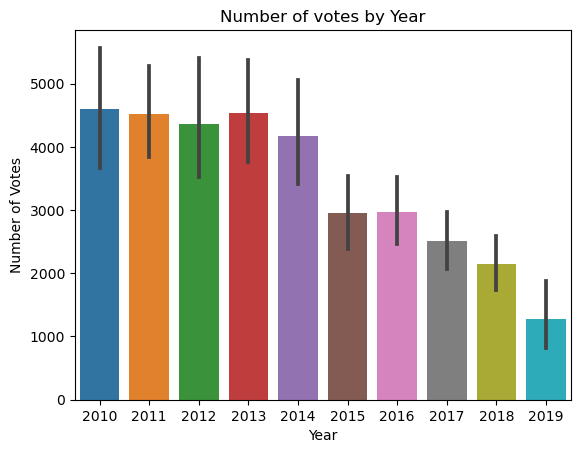

In [26]:
sns.barplot(x= movie_ratings_basics['start_year'], y = movie_ratings_basics['numvotes'], data = movie_ratings_basics)
plt.xlabel('Year')
plt.ylabel('Number of Votes')
plt.title('Number of votes by Year')
plt.show()

It looks like the number of votes has been decreasing with each passing year. The average number of year votes over the years has been decreasing too over the years

## Movie Runtimes over the years

In [27]:
runtime_grouped = movie_ratings_basics.groupby('start_year')['runtime_minutes'].mean().sort_values(ascending= False)
runtime_grouped

start_year
2012    98.327358
2019    97.750334
2018    95.691921
2017    94.078011
2011    93.487587
2016    93.108095
2015    92.914827
2014    92.776347
2010    92.016837
2013    92.003851
Name: runtime_minutes, dtype: float64

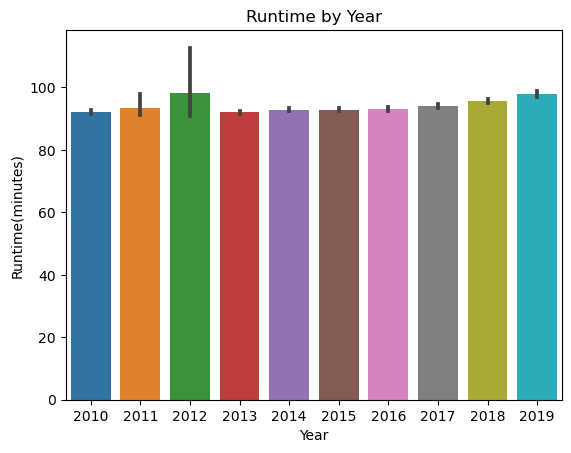

In [28]:
sns.barplot(x= movie_ratings_basics['start_year'], y = movie_ratings_basics['runtime_minutes'], data = movie_ratings_basics)
plt.xlabel('Year')
plt.ylabel('Runtime(minutes)')
plt.title('Runtime by Year')
plt.show()

It looks like the movie runtime haven\`t changed much over the years. The average runtime hasn\`t changed much too over the years

# Changing the ratings to values that we can evaluate

In [29]:
movie_ratings_basics['averagerating'].nunique()

91

In [30]:
movie_ratings_basics['averagerating'].max()

10.0

In [31]:
movie_ratings_basics['averagerating'].min()

1.0

We have 91 unique values in our average rating column making it difficult to analyse the data in relationship with other columns. The average rating column has maximum values of 10 and minimun values of 1. We can make our work easier by grouping the average rating into three groups of low, average and high. 
We will have the; 
- low rating being from 1-3 
- average rating from 4-6
- high rating from 7-10

In [32]:
def map_rating(value):
    if value >= 7:
        return 'High'
    elif value >= 4:
        return 'Average'
    else:
        return 'Low'

# Applying the custom function to the 'Average Rating' column
movie_ratings_basics['new_rating'] = movie_ratings_basics['averagerating'].apply(map_rating)
movie_ratings_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,new_rating
0,tt0063540,Sunghursh,Sunghursh,2013,175.000000,"Action,Crime,Drama",7.0,77,High
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.000000,"Biography,Drama",7.2,43,High
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.000000,Drama,6.9,4517,Average
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,86.261556,"Comedy,Drama",6.1,13,Average
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.000000,"Comedy,Drama,Fantasy",6.5,119,Average


## Relationship between the runtime and ratings

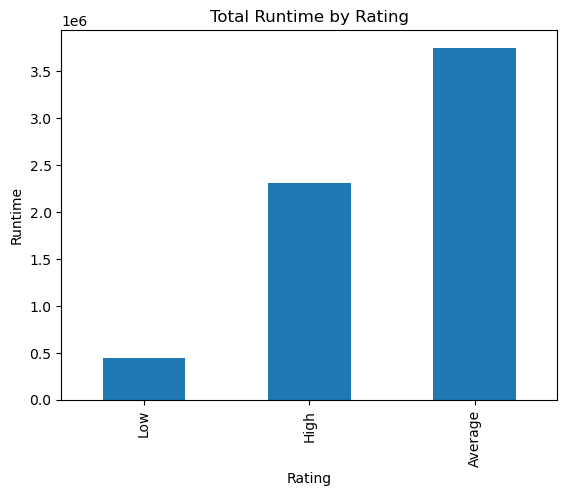

In [33]:
sum_grouped_runtime = movie_ratings_basics.groupby('new_rating')['runtime_minutes'].sum().sort_values()

sum_grouped_runtime.plot(kind='bar', x='new_rating', y='runtime')

plt.xlabel('Rating')
plt.ylabel('Runtime')
plt.title('Total Runtime by Rating')

plt.show()

These results show that:-
- Movies with an average rating tend to have a longer total runtime than movies with low ratings and  movies with high ratings.

- Movies with a average rating tend to have the longest total runtime, while movies with a low rating tend to have the shortest total runtime.

These observations could be explained by several factors. For example, movies with higher ratings may be more likely to have complex or intricate plots that require a longer runtime to fully develop. Additionally, movies with higher ratings may have more nuanced characters, more intricate cinematography, or more elaborate special effects that contribute to a longer total runtime. On the other hand, movies with lower ratings may be more formulaic or simplistic, and may not require as much time to fully tell their story.

#### Recommendation
So as to prevent your movie from getting a low rating you should have a more complex or intricate plot line that draws in audiences which would lead to a highly rated movie. This recommendation would be appropriate for movie directors and writers.


## Relationship between number of votes and average rating

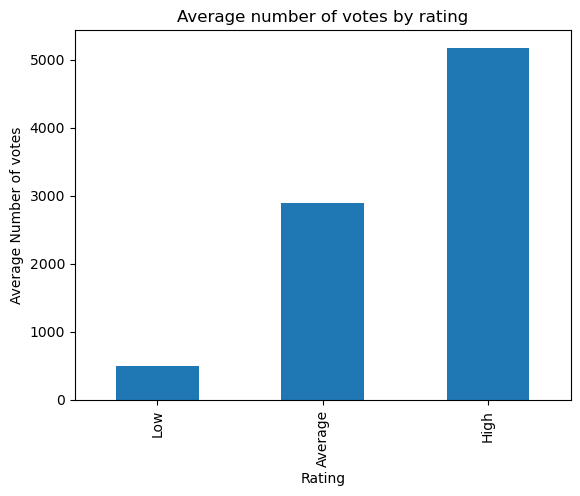

In [34]:
grouped_votes = movie_ratings_basics.groupby('new_rating')['numvotes'].mean().sort_values()

grouped_votes.plot(kind='bar', x='new_rating', y='numvotes')

plt.xlabel('Rating')
plt.ylabel('Average Number of votes')
plt.title('Average number of votes by rating')

plt.show()

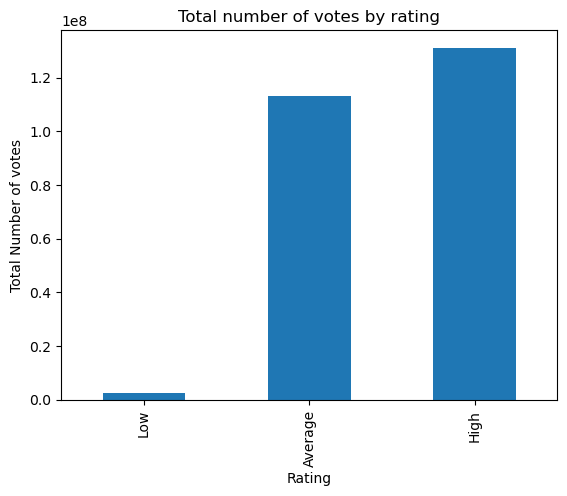

In [35]:
sum_grouped_votes = movie_ratings_basics.groupby('new_rating')['numvotes'].sum().sort_values()

sum_grouped_votes.plot(kind='bar', x='new_rating', y='numvotes')

plt.xlabel('Rating')
plt.ylabel('Total Number of votes')
plt.title('Total number of votes by rating')

plt.show()

These results show that:-
- Movies with a high rating tend to receive more votes than movies with low ratings, while movies with an average rating receive an intermediate number of votes.

- Movies with a low rating tend to receive the fewest votes overall.

These observations could be explained by several factors. For example, movies with higher ratings may have a larger fan base or a more dedicated following, leading to more votes from enthusiastic viewers. Additionally, movies with higher ratings may receive more critical acclaim or positive reviews, leading to more interest from general audiences.

On the other hand, movies with lower ratings may have less widespread appeal or may receive negative reviews, leading to fewer votes overall. It is also possible that movies with an average rating may be more likely to fall between the extremes of high and low ratings, leading to a less passionate response from viewers.

### Recommendation
If movie studios or producers would want their movies to be highly rated then it`s best to look at producing films that already have a fan base. This is evident in how movie studios go for books or comic books that already have a huge fan base. It is also the reason why movie studios sometimes reenact and produce sequels to their movies.

## Checking for missing values in movie_gross data

In [36]:
movie_gross.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

### Dropping the missing values in studio column in movie_gross data
Since only five values are missing in the studio column in the movie_gross data we can drop those missing values.

In [37]:
movie_gross = movie_gross.dropna(subset=['studio'])
movie_gross.isna().sum()

title                0
studio               0
domestic_gross      26
foreign_gross     1349
year                 0
dtype: int64

### Dropping the missing values in the domestic_gross column in the movie gross data

In [38]:
movie_gross['domestic_gross'].isna().sum()/len(movie_gross['domestic_gross'])

0.00768775872264932

In [39]:
movie_gross = movie_gross.dropna(subset=['domestic_gross'])
movie_gross.isna().sum()

title                0
studio               0
domestic_gross       0
foreign_gross     1349
year                 0
dtype: int64

Since the missing data in the domestic_gross column is only 0.77% we can drop the missing values rows. It won`t affect our analysis 

### Dropping the foreign_gross column in the movie_gross data

In [40]:
movie_gross['foreign_gross'].isna().sum()/len(movie_gross['foreign_gross'])

0.40196662693682955

Since 40% of the foreign gross column data is missing it\`s best to drop the whole column because we don\`t have enough data to enable us to replace the missing values and dropping the missing values rows would hugely affect our analysis

In [41]:
movie_gross = movie_gross.drop(['foreign_gross'], axis=1)

In [42]:
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3356 entries, 0 to 3386
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3356 non-null   object 
 1   studio          3356 non-null   object 
 2   domestic_gross  3356 non-null   float64
 3   year            3356 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 131.1+ KB


## Performance of movie studios over time looking at their gross incomes

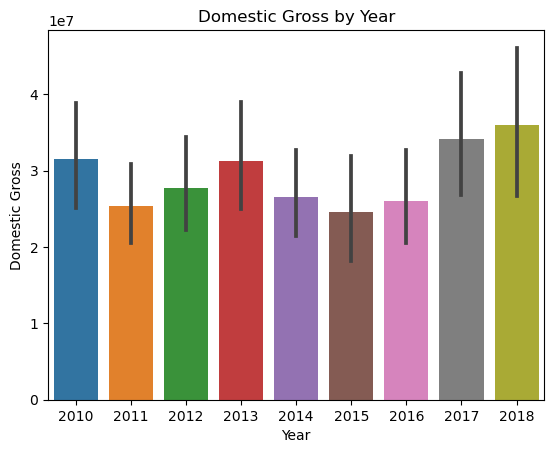

In [43]:
sns.barplot(x= movie_gross['year'], y = movie_gross['domestic_gross'], data = movie_gross)
plt.xlabel('Year')
plt.ylabel('Domestic Gross')
plt.title('Domestic Gross by Year')
plt.show()

The domestic gross earnings of the movie industry seem to be continously fluctuating

### Relationship showing the domestic gross performance of the top ten movie studios over the years

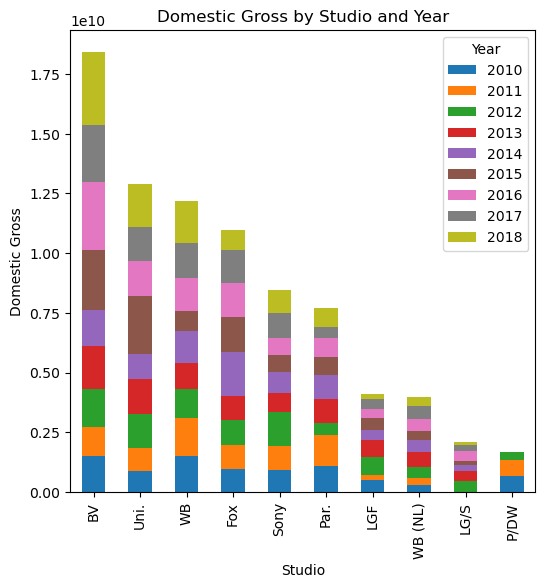

In [46]:
grouped_df = movie_gross.groupby(['year', 'studio'])['domestic_gross'].sum().reset_index()

# pivot the data to create a new DataFrame with each year as a column and each studio as a row
pivoted_df = pd.pivot_table(grouped_df, values='domestic_gross', index='studio', columns='year', fill_value=0)

# sort the data in descending order of total domestic gross
sorted_df = pivoted_df.sum(axis=1).sort_values(ascending=False).index[:10]
pivoted_df = pivoted_df.loc[sorted_df]

# create the stacked bar chart
pivoted_df.plot(kind='bar', stacked=True, figsize=(6,6))
plt.xlabel('Studio')
plt.ylabel('Domestic Gross')
plt.title('Domestic Gross by Studio and Year')
plt.legend(title='Year')
plt.show()


These results show the top ten best performing movie studios according to their domestic gross income over the years.In order, they include:-
1. BV (Buena Vista- owned by Walt Disney)
2. Uni. (Universal)
3. WB (Warner Bros)
4. Fox
5. Sony
6. Par. (Paramount)
7. LGF (Lions Gate Films)
8. WB(NL) (New Line Cinema - owned by Warner Bros)
9. LG/S 
10. P/DW (Dreamworks - owned by Viacom parent of Paramount)



### Recommendation
For investors looking to invest in movie studios, this visualization can be further analyzed to look at the studios that have maintained their earnings year over year before making an investment.  A high domestic gross revenue would most likely lead to rising cashflows and hence a rising stock price. If you are a film director getting the top ten movie studios to back you will most probably lead to your film grossing highly since backing of a studio with high cashflows might lead the studio to spend more money to make a better quality film and also in marketing the film.